#  Final Project
## Zillow Home Sell Price Predictions
### Cody Hoffman


---

In [1]:
reset -fs

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pmdarima as pm

%config InlineBackend.figure_format = 'svg'

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


## EDA

In [3]:
df = pd.read_csv(r"C:\Users\Grimmethy\Downloads\zillow_data.csv")

In [5]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName', 'RegionID', 'SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [7]:
df_main = melt_data(df)

In [9]:
df_cc = df_main[df_main["RegionName"] == 98118]

In [11]:
sellprice = df_cc['value']
sellprice.index = pd.DatetimeIndex(df_cc['time'])

In [19]:
sellprice_not_na = sellprice[~sellprice.isna()]

### Read, visualize raw data

In [20]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#### Line, ACF plots

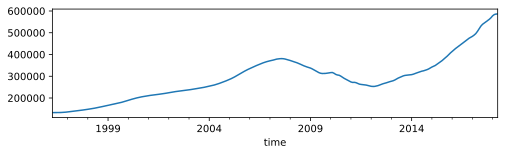

In [23]:
plt.figure(figsize=(8, 2))
sellprice.plot()
# plt.xticks(rotation=45)
plt.show()

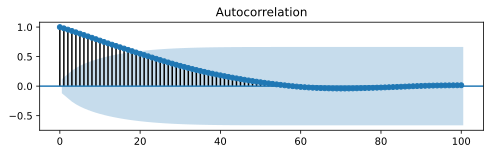

In [24]:
fig = plot_acf(sellprice_not_na, lags=100)
fig.set_size_inches(8, 2)
plt.show()

### Differencing

#### 1-time trend differencing

In [25]:
sellprice_d1 = pd.Series(np.diff(sellprice_not_na.values, n=1),
                           index=sellprice_not_na.index[1:])

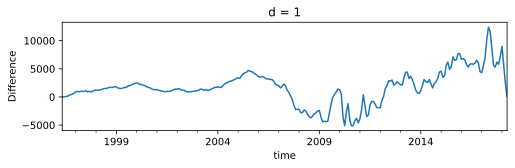

In [26]:
plt.figure(figsize=(8, 2))
sellprice_d1.plot()
plt.ylabel('Difference')
plt.title('d = 1')
plt.show()

In [27]:
adf_test(sellprice_d1)

Results of Dickey-Fuller Test:
Test Statistic                  -1.948085
p-value                          0.309789
#Lags Used                      15.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


#### 2-time trend differencing

In [28]:
sellprice_d2 = pd.Series(np.diff(sellprice_not_na.values, n=2),
                           index=sellprice_not_na.index[2:])

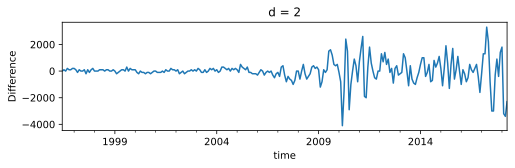

In [29]:
plt.figure(figsize=(8, 2))
sellprice_d2.plot()
plt.ylabel('Difference')
plt.title('d = 2')
plt.show()

In [30]:
adf_test(sellprice_d2)

Results of Dickey-Fuller Test:
Test Statistic                  -3.791637
p-value                          0.002994
#Lags Used                      14.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


#### 3-time trend differencing

In [31]:
sellprice_d3 = pd.Series(np.diff(sellprice_not_na.values, n=3),
                           index=sellprice_not_na.index[3:])

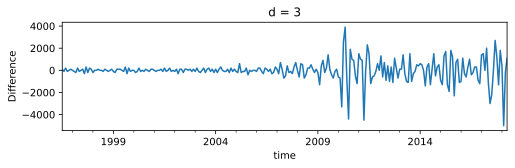

In [32]:
plt.figure(figsize=(8, 2))
sellprice_d3.plot()
plt.ylabel('Difference')
plt.title('d = 3')
plt.show()

In [33]:
adf_test(sellprice_d3)

Results of Dickey-Fuller Test:
Test Statistic                -7.478539e+00
p-value                        4.840796e-11
#Lags Used                     1.300000e+01
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


#### 1-time seasonal differencing on 2-time trend differencing

There appears to be slight seasonality with lag 12, according to the 1-time differencing line plot.

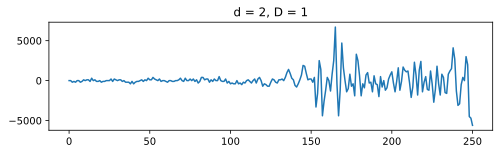

In [34]:
sellprice_d2_D1 = []
for i in range(12, len(sellprice_d2)):
    value = sellprice_d2[i] - sellprice_d2[i - 12]  # lag is 12 (seasonal lag is 1 year, or 12 months)
    sellprice_d2_D1.append(value)
plt.figure(figsize=(8, 2))
plt.title('d = 2, D = 1')
plt.plot(sellprice_d2_D1) 
plt.show()

In [35]:
adf_test(sellprice_d2_D1)

Results of Dickey-Fuller Test:
Test Statistic                  -4.548848
p-value                          0.000160
#Lags Used                      14.000000
Number of Observations Used    236.000000
Critical Value (1%)             -3.458366
Critical Value (5%)             -2.873866
Critical Value (10%)            -2.573339
dtype: float64


#### 2-time seasonal differencing on 2-time trend differencing

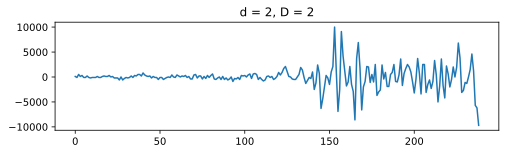

In [36]:
sellprice_d2_D2 = []
for i in range(12, len(sellprice_d2_D1)):
    value = sellprice_d2_D1[i] - sellprice_d2_D1[i - 12]  # lag is 12 (seasonal lag is 1 year, or 12 months)
    sellprice_d2_D2.append(value)
plt.figure(figsize=(8, 2))
plt.title('d = 2, D = 2')
plt.plot(sellprice_d2_D2) 
plt.show()

In [37]:
adf_test(sellprice_d2_D2)

Results of Dickey-Fuller Test:
Test Statistic                  -5.104082
p-value                          0.000014
#Lags Used                      14.000000
Number of Observations Used    224.000000
Critical Value (1%)             -3.459885
Critical Value (5%)             -2.874531
Critical Value (10%)            -2.573694
dtype: float64


---

## Best SARIMA-class model

### d = 1, D = 2

In [38]:
train_size = int(len(sellprice_not_na) * 0.80)
train, valid = sellprice_not_na[:train_size], sellprice_not_na[train_size:]
test = sellprice[sellprice.index >= pd.to_datetime('2016')]

In [39]:
model_d1_D2 = pm.auto_arima(train, start_p=1, start_q=1,
                            max_p=3, max_q=3, m=12,  # seasonal lag = 12
                            start_P=0, seasonal=True,
                            d=1, D=2, trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,2,1)[12]             : AIC=inf, Time=2.03 sec
 ARIMA(0,1,0)(0,2,0)[12]             : AIC=3545.297, Time=0.07 sec
 ARIMA(1,1,0)(1,2,0)[12]             : AIC=3507.625, Time=1.66 sec
 ARIMA(0,1,1)(0,2,1)[12]             : AIC=inf, Time=1.31 sec
 ARIMA(1,1,0)(0,2,0)[12]             : AIC=3519.605, Time=0.39 sec
 ARIMA(1,1,0)(2,2,0)[12]             : AIC=3474.941, Time=3.91 sec
 ARIMA(1,1,0)(2,2,1)[12]             : AIC=inf, Time=5.27 sec
 ARIMA(1,1,0)(1,2,1)[12]             : AIC=inf, Time=2.01 sec
 ARIMA(0,1,0)(2,2,0)[12]             : AIC=3526.267, Time=0.72 sec
 ARIMA(2,1,0)(2,2,0)[12]             : AIC=3491.337, Time=2.60 sec
 ARIMA(1,1,1)(2,2,0)[12]             : AIC=3455.598, Time=4.33 sec
 ARIMA(1,1,1)(1,2,0)[12]             : AIC=3489.715, Time=2.33 sec
 ARIMA(1,1,1)(2,2,1)[12]             : AIC=inf, Time=6.15 sec
 ARIMA(1,1,1)(1,2,1)[12]             : AIC=inf, Time=2.70 sec
 ARIMA(0,1,1)(2,2,0)[12]             : AIC=3492.4

In [40]:
model_d1_D2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  212
Model:             SARIMAX(1, 1, 1)x(2, 2, [], 12)   Log Likelihood               -1722.799
Date:                             Sun, 08 Nov 2020   AIC                           3455.598
Time:                                     15:11:40   BIC                           3471.753
Sample:                                          0   HQIC                          3462.144
                                             - 212                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8063      0.037     21.812      0.000       0.734       0.879
ma.L1         -0.5299      0.039    -13.563      0.000      -0.606      -0.453
ar.S.L12      -0.3802      0.010    -36.463      0.000      -0.401      -0.360
ar.S.L24      -0.1591      0.005    -33.224      0.000      -0.168      -0.150
sigma2      4.795e+06   1.75e-09   2.74e+15      0.000     4.8e+06     4.8e+06
===================================================================================
Ljung-Box (Q):                      108.07   Jarque-Bera (JB):               377.55
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                             0.56
Prob(H) (two-sided):                  0.37   Kurtosis:                         9.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.69e+30. Standard errors may be unstable.
"""

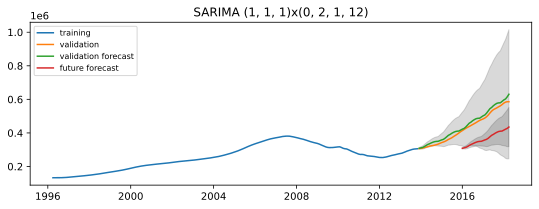

In [41]:
fc1, conf1 = model_d1_D2.predict(len(valid), return_conf_int=True, alpha=0.05)
fc2, conf2 = model_d1_D2.predict(len(test), return_conf_int=True, alpha=0.05)
fc_series1 = pd.Series(fc1, index=valid.index)
fc_series2 = pd.Series(fc2, index=test.index)

lower_series1 = pd.Series(conf1[:, 0], index=valid.index)
upper_series1 = pd.Series(conf1[:, 1], index=valid.index)
lower_series2 = pd.Series(conf2[:, 0], index=test.index)
upper_series2 = pd.Series(conf2[:, 1], index=test.index)

# Plot
plt.figure(figsize=(9, 3))
plt.plot(train, label='training')
plt.plot(valid, label='validation')
plt.plot(fc_series1, label='validation forecast')
plt.plot(fc_series2, label='future forecast')

plt.fill_between(lower_series1.index, lower_series1, upper_series1, color='k', alpha=.15)
plt.fill_between(lower_series2.index, lower_series2, upper_series2, color='k', alpha=.15)

plt.title('SARIMA (1, 1, 1)x(0, 2, 1, 12)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### Evaluation

In [42]:
mse = ((fc_series1 - valid) ** 2).mean()
rmse=round(np.sqrt(mse), 2)
print(rmse)

19735.06


### SARIMA (1, 1, 1) x (0, 2, 1, 12) Forecasting

In [43]:
train = sellprice_not_na
test = sellprice[sellprice.index >= pd.to_datetime('2016')]

In [44]:
model_d1_D2_all = pm.auto_arima(train, start_p=1, start_q=1,
                                max_p=3, max_q=3, m=12,  # seasonal lag = 12
                                start_P=0, seasonal=True,
                                d=1, D=2, trace=True,
                                error_action='ignore',  
                                suppress_warnings=True, 
                                stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,2,1)[12]             : AIC=inf, Time=2.44 sec
 ARIMA(0,1,0)(0,2,0)[12]             : AIC=4597.418, Time=0.08 sec
 ARIMA(1,1,0)(1,2,0)[12]             : AIC=4529.270, Time=2.00 sec
 ARIMA(0,1,1)(0,2,1)[12]             : AIC=inf, Time=1.63 sec
 ARIMA(1,1,0)(0,2,0)[12]             : AIC=4555.634, Time=0.46 sec
 ARIMA(1,1,0)(2,2,0)[12]             : AIC=4468.499, Time=2.27 sec
 ARIMA(1,1,0)(2,2,1)[12]             : AIC=inf, Time=3.47 sec
 ARIMA(1,1,0)(1,2,1)[12]             : AIC=inf, Time=1.53 sec
 ARIMA(0,1,0)(2,2,0)[12]             : AIC=4560.040, Time=0.96 sec
 ARIMA(2,1,0)(2,2,0)[12]             : AIC=4457.807, Time=6.33 sec
 ARIMA(2,1,0)(1,2,0)[12]             : AIC=4520.947, Time=2.85 sec
 ARIMA(2,1,0)(2,2,1)[12]             : AIC=inf, Time=9.05 sec
 ARIMA(2,1,0)(1,2,1)[12]             : AIC=inf, Time=3.59 sec
 ARIMA(3,1,0)(2,2,0)[12]             : AIC=4485.594, Time=3.65 sec
 ARIMA(2,1,1)(2,2,0)[12]             : AIC=4482.6

In [45]:
model_d1_D2_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(2, 2, [], 12)   Log Likelihood               -2223.112
Date:                             Sun, 08 Nov 2020   AIC                           4456.224
Time:                                     15:15:28   BIC                           4473.627
Sample:                                          0   HQIC                          4463.236
                                             - 265                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7393      0.057     12.893      0.000       0.627       0.852
ma.L1         -0.2875      0.057     -5.015      0.000      -0.400      -0.175
ar.S.L12      -0.4793      0.008    -58.726      0.000      -0.495      -0.463
ar.S.L24      -0.1969      0.004    -48.543      0.000      -0.205      -0.189
sigma2       5.44e+06   4.31e-09   1.26e+15      0.000    5.44e+06    5.44e+06
===================================================================================
Ljung-Box (Q):                       59.95   Jarque-Bera (JB):              1356.99
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                             0.36
Prob(H) (two-sided):                  0.13   Kurtosis:                        14.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.1e+30. Standard errors may be unstable.
"""

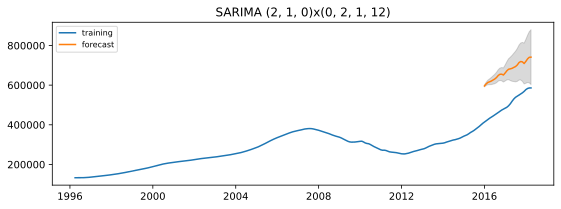

In [46]:
fc, conf = model_d1_D2_all.predict(len(test), return_conf_int=True, alpha=0.05)
fc_series = pd.Series(fc, index=test.index)

lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(9, 3))
plt.plot(train, label='training')
plt.plot(fc_series, label='forecast')

plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

plt.title('SARIMA (2, 1, 0)x(0, 2, 1, 12)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Best SARIMA Log-Transformed Model

## Model selection with Auto-ARIMA

In [47]:
def create_training_splits(data, log=False):
    
    train_size = int(len(data) * 0.8)
    
    train = data[:train_size]
    valid = data[train_size:]
    
    # Hardcoded
    test = sellprice[sellprice.index >= pd.to_datetime('2016')] 
    
    if log: 
        return np.log(train), np.log(valid), np.log(test)
    else: 
        return train, valid, test

In [48]:
train, valid, test = create_training_splits(sellprice_not_na)

In [49]:
logtrain, logvalid, logtest = create_training_splits(sellprice_not_na, log=True)

In [50]:
fulldata = sellprice_not_na

In [51]:
logfull = np.log(fulldata)

### d = 1, D = 1

In [52]:
log_model_d1_D1 = pm.auto_arima(logtrain, start_p=1, start_q=1,
                                max_p=3, max_q=3, m=12,  # seasonal lag = 12
                                start_P=0, seasonal=True,
                                d=1, D=1, trace=True,
                                error_action='ignore',  
                                suppress_warnings=True, 
                                stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-1749.031, Time=0.58 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-1387.207, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-1753.192, Time=0.83 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-1573.281, Time=0.94 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-1688.879, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-1762.758, Time=2.29 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=-1767.566, Time=2.32 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=-1768.148, Time=1.25 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-1717.973, Time=0.15 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=-1772.317, Time=2.25 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=-1785.812, Time=2.27 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=-1399.765, Time=3.67 sec
 ARIMA(2,1,0)(0,1,2)[12]             : AIC=-1762.681, Time=1.61 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=-1773.090, Time=2.14 sec
 ARIM

In [53]:
log_model_d1_D1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  212
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 911.349
Date:                            Sun, 08 Nov 2020   AIC                          -1810.697
Time:                                    15:17:38   BIC                          -1790.937
Sample:                                         0   HQIC                         -1802.700
                                            - 212                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.679e-05      0.000     -0.314      0.753      -0.000       0.000
ar.L1          0.3650      0.084      4.347      0.000       0.200       0.530
ar.L2          0.4876      0.078      6.231      0.000       0.334       0.641
ma.L1          0.8111      0.064     12.601      0.000       0.685       0.937
ma.S.L12      -0.7197      0.044    -16.299      0.000      -0.806      -0.633
sigma2      5.816e-06   3.53e-07     16.489      0.000    5.12e-06    6.51e-06
===================================================================================
Ljung-Box (Q):                      143.74   Jarque-Bera (JB):               555.59
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              25.62   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

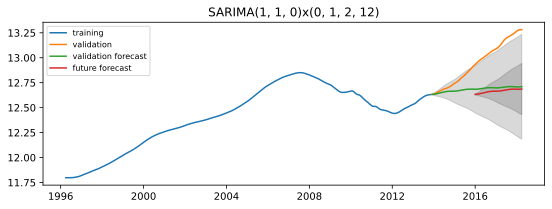

In [54]:
fc1, conf1 = log_model_d1_D1.predict(len(logvalid), return_conf_int=True, alpha=0.05)
fc2, conf2 = log_model_d1_D1.predict(len(logtest), return_conf_int=True, alpha=0.05)
fc_series1 = pd.Series(fc1, index=logvalid.index)
fc_series2 = pd.Series(fc2, index=logtest.index)

lower_series1 = pd.Series(conf1[:, 0], index=logvalid.index)
upper_series1 = pd.Series(conf1[:, 1], index=logvalid.index)
lower_series2 = pd.Series(conf2[:, 0], index=logtest.index)
upper_series2 = pd.Series(conf2[:, 1], index=logtest.index)

# Plot
plt.figure(figsize=(9, 3))
plt.plot(logtrain, label='training')
plt.plot(logvalid, label='validation')
plt.plot(fc_series1, label='validation forecast')
plt.plot(fc_series2, label='future forecast')

plt.fill_between(lower_series1.index, lower_series1, upper_series1, color='k', alpha=.15)
plt.fill_between(lower_series2.index, lower_series2, upper_series2, color='k', alpha=.15)

plt.title('SARIMA(1, 1, 0)x(0, 1, 2, 12)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### Evaluation

In [55]:
mse = ((fc_series1 - logvalid) ** 2).mean()
rmse=round(np.sqrt(mse), 2)
print(rmse)

0.32


#### Transformed Back

In [56]:
mse = ((np.exp(fc_series1) - valid) ** 2).mean()
rmse=round(np.sqrt(mse), 2)
print(rmse)

134343.62


### Training Model on Full Data

In [57]:
log_model_d1_D1_full = pm.auto_arima(logfull, start_p=1, start_q=1,
                            max_p=3, max_q=3, m=12,  # seasonal lag = 12
                            start_P=0, seasonal=True,
                            d=1, D=1, trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-2222.942, Time=0.73 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-1764.417, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-2138.536, Time=0.29 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-2002.534, Time=0.90 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=-2156.542, Time=0.32 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-2222.553, Time=0.87 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=-2230.481, Time=2.98 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=-2229.896, Time=1.89 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-1992.531, Time=2.48 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=-2190.053, Time=2.19 sec
 ARIMA(2,1,1)(0,1,2)[12]             : AIC=-2282.535, Time=5.92 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=-2256.935, Time=1.77 sec
 ARIMA(2,1,1)(1,1,2)[12]             : AIC=-2271.597, Time=5.08 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=-2281.760, Time=2.11 sec
 ARIM

In [58]:
log_model_d1_D1_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  265
Model:             SARIMAX(2, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood                1154.189
Date:                                 Sun, 08 Nov 2020   AIC                          -2294.377
Time:                                         15:19:42   BIC                          -2269.671
Sample:                                              0   HQIC                         -2284.436
                                                 - 265                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.101e-05      0.000      0.204      0.839      -0.000       0.000
ar.L1          0.4974      0.082      6.081      0.000       0.337       0.658
ar.L2          0.3813      0.082      4.671      0.000       0.221       0.541
ma.L1          0.7800      0.057     13.571      0.000       0.667       0.893
ma.S.L12      -0.9173      0.035    -26.328      0.000      -0.986      -0.849
ma.S.L24       0.2506      0.044      5.752      0.000       0.165       0.336
sigma2      5.826e-06   2.91e-07     20.016      0.000    5.26e-06     6.4e-06
===================================================================================
Ljung-Box (Q):                      109.89   Jarque-Bera (JB):               316.90
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              13.59   Skew:                            -0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

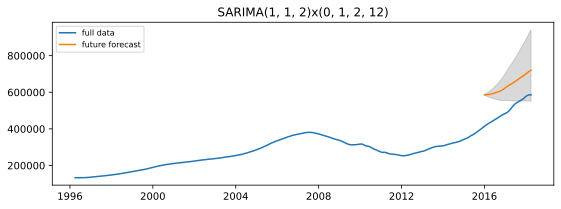

In [59]:
fc1, conf1 = log_model_d1_D1_full.predict(len(logtest), return_conf_int=True, alpha=0.05)
fc_series1 = pd.Series(np.exp(fc1), index=logtest.index)

lower_series1 = np.exp(pd.Series(conf1[:, 0], index=logtest.index))
upper_series1 = np.exp(pd.Series(conf1[:, 1], index=logtest.index))


# Plot
plt.figure(figsize=(9, 3))
plt.plot(np.exp(logfull), label='full data')
plt.plot(fc_series1, label='future forecast')

plt.fill_between(lower_series1.index, lower_series1, upper_series1, color='k', alpha=.15)

plt.title('SARIMA(1, 1, 2)x(0, 1, 2, 12)')
plt.legend(loc='upper left', fontsize=8)
plt.show()